In [291]:
import numpy as np
import pandas as pd
import toolsets.auto_rt_pred as ap
import toolsets.data_prep as data_prep
import toolsets.feature_engineering as se
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_validate, KFold
import random
import time
import scipy.stats as st
from autogluon.tabular import TabularDataset, TabularPredictor
import statistics
from tqdm import tqdm 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# data of acetonitrile as organic modifier

In [149]:
combined_data = pd.read_csv("data/multiRT/Combined dataset.csv")
hilic = combined_data.loc[combined_data['Column']=='HILIC']
hilic_Ace = hilic.loc[hilic['Organic_modifier']=='Acetonitrile']
hilic_Ace.reset_index(inplace=True, drop=True)

In [17]:
descriptors_Ace = ap.make_descriptors(hilic_Ace)
descriptors_Ace.to_csv('hilic_Ace_descriptors.csv', index = False)
# For quick use

In [150]:
descriptors_Ace = pd.read_csv('hilic_Ace_descriptors.csv')

In [151]:
descriptors_Ace.shape

(414, 1613)

In [152]:
# Clean up object dtype in descriptors
descriptors_Ace = se.cleanup_descriptros(descriptors_Ace)

In [153]:
descriptors_Ace.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
descriptors_Ace.shape

(414, 1509)

In [126]:
descriptors_Ace['MDEC-44'].isnull().sum()

367

In [156]:
# Impute missing value
imp_mean = SimpleImputer(strategy='constant', fill_value = 0)
descriptors_Ace_t = imp_zero.fit_transform(descriptors_Ace)
descriptors_Ace_p = pd.DataFrame(descriptors_Ace_t,columns = descriptors_Ace.columns)

In [157]:
descriptors_Ace_p.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
1,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
2,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
3,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
4,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0


In [158]:
data_ace = pd.concat([hilic_Ace, descriptors_Ace_p], axis = 1)
data_ace = data_prep.dataset_prep(data_ace)

In [159]:
data_ace.head()

,Compound_name,Column,Organic_modifier,pH,Buffer,SMILES,retention_time,ABC,ABCGG,nAcid,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,1-hydroxypyrene,HILIC,Acetonitrile,2.7,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.822857,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
1,1-hydroxypyrene,HILIC,Acetonitrile,3.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,12.321429,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
2,1-hydroxypyrene,HILIC,Acetonitrile,3.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.857143,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
3,1-hydroxypyrene,HILIC,Acetonitrile,5.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.850000,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
4,1-hydroxypyrene,HILIC,Acetonitrile,5.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.851429,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
len(data_ace)

414

In [13]:
len(data_met)

422

In [167]:
# Make X,y of data_ace 
X = data_ace.drop(['retention_time','Compound_name','Column','Organic_modifier','Buffer','SMILES'], axis =1)
y = data_ace['retention_time']

In [169]:
# data_ace leave-one-out predict
SEED = 123456
np.random.seed(SEED)
random.seed(SEED)

kf = KFold(n_splits = len(data_ace), shuffle = True, random_state = 2)
kf.get_n_splits(X)

start = time.time()    
diff_distribution = pd.Series([])
clf = RandomForestRegressor(n_jobs=-1)
for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    diff_distribution_temp = pd.Series(y_test - y_pred)
    diff_distribution = diff_distribution.append(diff_distribution_temp)
end = time.time()

k-fold: 100%|████████████████████████████████████████████████████████████████████████| 414/414 [07:45<00:00,  1.12s/it]


In [170]:
diff_distribution.to_csv('diff_distribution_ace.csv')

In [ ]:
# diff_distribution = pd.read_csv('diff_distribution_ace.csv', index_col=0)
# For quick use

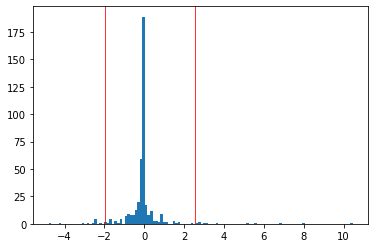

In [397]:
# Plot difference distribution between predict values and real values
plt.hist(diff_distribution, bins = 120)
plt.axvline(x = diff_distribution.quantile(.025), color = 'r', linewidth = 0.8)
plt.axvline(x = diff_distribution.quantile(.975), color = 'r', linewidth = 0.8)

In [171]:
# Performance of model on training dataset
clf.score(X_train, y_train)

0.8821609634773602

In [172]:
print((end-start)/60)

7.757790637016297


In [173]:
print(len(diff_distribution))

414


In [174]:
outlier_indices = diff_distribution[(diff_distribution < diff_distribution.quantile(.025))|
                                    (diff_distribution > diff_distribution.quantile(.975))].index

In [175]:
outlier_indices

Int64Index([ 70,  84, 289,   2,  67,  69, 237,   1, 362, 354, 230, 355, 399,
            122,   0, 364, 208, 353, 229, 288,  83, 363],
           dtype='int64')

In [176]:
y[outlier_indices]

70      1.747143
84      1.916000
289     7.558571
2       1.857143
67      1.780000
69      8.115714
237     5.370000
1      12.321429
362     1.995714
354     9.880000
230     7.534286
355     1.960000
399    11.001429
122    11.150000
0       1.822857
364     1.990000
208     9.952857
353     1.868000
229    11.588571
288    11.357143
83      7.070000
363     8.880000
Name: retention_time, dtype: float64

In [177]:
data_ace.loc[outlier_indices]

,Compound_name,Column,Organic_modifier,pH,Buffer,SMILES,retention_time,ABC,ABCGG,nAcid,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
70,Bicalutamide,HILIC,Acetonitrile,5.0,Acetic acid,C[C@](CS(=O)(=O)c1ccc(cc1)F)(C(=Nc1ccc(C#N)c(c...,1.747143,22.319145,18.909716,0,...,0.166667,1.639769,0,0,0,0.166667,0,0,0,0
84,Carbazole,HILIC,Acetonitrile,3.0,Formic acid,c1ccc2c(c1)c1ccccc1[nH]2,1.916000,10.485281,8.835388,0,...,0,0,0,0,0,0,0,0,0,0
289,O-Desmethylvenlafaxine,HILIC,Acetonitrile,3.0,Formic acid,CN(C)CC(c1ccc(cc1)O)C1(CCCCC1)O,7.558571,14.527174,12.678904,0,...,0,0.142857,0,0,0,0,0,0,0,0
2,1-hydroxypyrene,HILIC,Acetonitrile,3.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.857143,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
67,Bicalutamide,HILIC,Acetonitrile,2.7,Formic acid,C[C@](CS(=O)(=O)c1ccc(cc1)F)(C(=Nc1ccc(C#N)c(c...,1.780000,22.319145,18.909716,0,...,0.166667,1.639769,0,0,0,0.166667,0,0,0,0
69,Bicalutamide,HILIC,Acetonitrile,3.0,Formic acid,C[C@](CS(=O)(=O)c1ccc(cc1)F)(C(=Nc1ccc(C#N)c(c...,8.115714,22.319145,18.909716,0,...,0.166667,1.639769,0,0,0,0.166667,0,0,0,0
237,Melamine,HILIC,Acetonitrile,5.0,Acetic acid,c1(=N)[nH]c(=N)[nH]c(=N)[nH]1,5.370000,6.69213,6.355891,0,...,0,0,0,0,0.75,3.571652,0,1.5,0,0
1,1-hydroxypyrene,HILIC,Acetonitrile,3.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,12.321429,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
362,Sulfamethazine,HILIC,Acetonitrile,2.7,Formic acid,Cc1cc(C)nc(n1)NS(=O)(=O)c1ccc(cc1)N,1.995714,14.726533,12.49165,0,...,0,0.5,0,0,0,0.412741,0,1.5,0,0
354,Simvastatin,HILIC,Acetonitrile,5.0,Acetic acid,CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)...,9.880000,23.268833,18.862705,0,...,0,0.382096,1.259921,0.142857,0,0,0,0,0,0


In [178]:
data_ace_clean = data_ace.drop(outlier_indices)

In [179]:
data_ace_clean.head()

,Compound_name,Column,Organic_modifier,pH,Buffer,SMILES,retention_time,ABC,ABCGG,nAcid,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
3,1-hydroxypyrene,HILIC,Acetonitrile,5.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.850000,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
4,1-hydroxypyrene,HILIC,Acetonitrile,5.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.851429,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
5,1-hydroxypyrene,HILIC,Acetonitrile,6.7,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.930000,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
6,1-Nitropyrene,HILIC,Acetonitrile,2.7,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)N(=O)=O,2.373333,15.492048,11.735103,0,...,0,0.5,0,0,0,0,0,0,0,0
7,1-Nitropyrene,HILIC,Acetonitrile,3.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)N(=O)=O,2.338000,15.492048,11.735103,0,...,0,0.5,0,0,0,0,0,0,0,0


# data quality evalution by using RF, AutoGluon

In [207]:
#  Original data evalution
train, test = data_prep.make_train_test(data_ace)
X_train = train.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_train = train['retention_time']
X_test = test.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_test = test['retention_time']

this dataset has split index already


In [208]:
X_train.shape

(343, 1510)

In [198]:
# Random Forest Regressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [199]:
clf.score(X_train, y_train)

0.9084433970910314

In [200]:
clf.score(X_test, y_test)

0.5027231408981262

In [201]:
# AutoGluon
ap.autogluon_fit_train_test(train, test, 'not_cleaned_ace')

Beginning AutoGluon training ...
AutoGluon will save models to "not_cleaned\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    343
Train Data Columns: 1513
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (11.357142857142858, 1.1528571428571428, 3.01138, 2.03688)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9303.95 MB
	Train Data (Original)  Memory Usage: 16.71 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -1.296376       0.963367   59.046994                0.002150           0.174040            2       True         11
1       RandomForestMSE  -1.298485       0.212048    2.597473                0.212048           2.597473            1       True          5
2         ExtraTreesMSE  -1.309251       0.464105    1.272286                0.464105           1.272286            1       True          7
3               XGBoost  -1.362660       0.228052   19.267842                0.228052          19.267842            1       True          8
4              LightGBM  -1.416349       0.216049    1.507339                0.216049           1.507339            1       True          4
5            LightGBMXT  -1.426967       0.218050    2.208055                0.218050           2.

Evaluation: root_mean_squared_error on test data: -1.5639982910567298
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.5639982910567298,
    "mean_squared_error": -2.446090654428371,
    "mean_absolute_error": -0.5566289560783637,
    "r2": 0.5306660520825583,
    "pearsonr": 0.731596448100172,
    "median_absolute_error": -0.1077638013022284
}


{'root_mean_squared_error': -1.5639982910567298, 'mean_squared_error': -2.446090654428371, 'mean_absolute_error': -0.5566289560783637, 'r2': 0.5306660520825583, 'pearsonr': 0.731596448100172, 'median_absolute_error': -0.1077638013022284}


In [209]:
# Data evalution after cleanded mislabelled data 
train_clean, test_clean = data_prep.make_train_test(data_ace_clean)
X_train = train_clean.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_train = train_clean['retention_time']
X_test = test_clean.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_test = test_clean['retention_time']

this dataset has split index already


In [203]:
X_train.shape

(325, 1510)

In [210]:
# Random Forest Regressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [211]:
clf.score(X_train, y_train)

0.973501931524799

In [212]:
clf.score(X_test, y_test)
# much better than original data of around 0.5

0.8882255530360545

In [213]:
# AutoGluon
ap.autogluon_fit_train_test(train_clean, test_clean, 'cleaned_ace')
# much better than original data as well

Beginning AutoGluon training ...
AutoGluon will save models to "cleaned\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    325
Train Data Columns: 1513
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (10.268571428571429, 1.0871428571428572, 2.86067, 1.72815)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9106.27 MB
	Train Data (Original)  Memory Usage: 15.83 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to 

[1000]	valid_set's rmse: 0.616785
[2000]	valid_set's rmse: 0.59312


	-0.5918	 = Validation score   (root_mean_squared_error)
	2.13s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.5518	 = Validation score   (root_mean_squared_error)
	2.31s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: CatBoost ...
	-0.743	 = Validation score   (root_mean_squared_error)
	175.73s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.5927	 = Validation score   (root_mean_squared_error)
	1.3s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
		cannot import name 'cbook' from partially initialized module 'matplotlib' (most likely due to a circular import) (D:\Users\halle\envs\pytorch\lib\site-packages\matplotlib\__init__.py)
Fitting model: XGBoost ...
	-0.5172	 = Validation score   (root_mean_squared_error)
	17.9s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.7918	 = Validation score   (root_mean_squar

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.505356       1.308295  198.278939                0.001000           0.175040            2       True         11
1               XGBoost  -0.517195       0.164037   17.904797                0.164037          17.904797            1       True          8
2       RandomForestMSE  -0.551835       0.483109    2.313522                0.483109           2.313522            1       True          5
3              LightGBM  -0.591834       0.222051    2.130480                0.222051           2.130480            1       True          4
4         ExtraTreesMSE  -0.592650       0.223051    1.295302                0.223051           1.295302            1       True          7
5         LightGBMLarge  -0.620155       0.220050    1.548350                0.220050           1.

Evaluation: root_mean_squared_error on test data: -0.5601999590741427
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.5601999590741427,
    "mean_squared_error": -0.31382399414667106,
    "mean_absolute_error": -0.29071988790697806,
    "r2": 0.9056744931428483,
    "pearsonr": 0.9613195274776207,
    "median_absolute_error": -0.12017475128173838
}


{'root_mean_squared_error': -0.5601999590741427, 'mean_squared_error': -0.31382399414667106, 'mean_absolute_error': -0.29071988790697806, 'r2': 0.9056744931428483, 'pearsonr': 0.9613195274776207, 'median_absolute_error': -0.12017475128173838}


# data of methanol as organic modifier

In [ ]:
# same steps with process data of acetonitrile as organic modifier

In [216]:
hilic_met = hilic.loc[hilic['Organic_modifier']=='Methanol']
hilic_met.reset_index(inplace=True, drop=True)

In [217]:
descriptors_met = ap.make_descriptors(hilic_met)
descriptors_met.to_csv('hilic_met_descriptors.csv', index = False)

In [218]:
descriptors_met = pd.read_csv('hilic_met_descriptors.csv')
# For quick use

In [219]:
# Clean up object dtype in descriptors
descriptors_met = se.cleanup_descriptros(descriptors_met)

In [220]:
descriptors_met.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
# Impute missing value
imp_mean = SimpleImputer(strategy='constant', fill_value = 0)
descriptors_met_t = imp_zero.fit_transform(descriptors_met)
descriptors_met_p = pd.DataFrame(descriptors_met_t,columns = descriptors_met.columns)

In [222]:
descriptors_met_p.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
1,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
2,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
3,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0
4,14.008885,10.537147,0,0,23.372976,2.54742,5.09484,23.372976,1.374881,3.826456,...,0,0,0,0,0,0,0,0,0,0


In [223]:
data_met = pd.concat([hilic_met, descriptors_met_p], axis = 1)
data_met = data_prep.dataset_prep(data_met)

In [224]:
data_met.head()

,Compound_name,Column,Organic_modifier,pH,Buffer,SMILES,retention_time,ABC,ABCGG,nAcid,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,1-hydroxypyrene,HILIC,Methanol,2.7,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.794286,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
1,1-hydroxypyrene,HILIC,Methanol,3.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.545714,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
2,1-hydroxypyrene,HILIC,Methanol,3.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.790000,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
3,1-hydroxypyrene,HILIC,Methanol,5.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.534286,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
4,1-hydroxypyrene,HILIC,Methanol,5.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.792857,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
# Make X,y of data_met 
X = data_met.drop(['retention_time','Compound_name','Column','Organic_modifier','Buffer','SMILES'], axis =1)
y = data_met['retention_time']

In [245]:
# data_met leave-one-out predict
SEED = 123456
np.random.seed(SEED)
random.seed(SEED)

kf = KFold(n_splits = len(data_met), shuffle = True, random_state = 2)
kf.get_n_splits(X)
   
diff_distribution = pd.Series([])
clf = RandomForestRegressor(n_jobs=-1)
for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    diff_distribution_temp = pd.Series(y_test - y_pred)
    diff_distribution = diff_distribution.append(diff_distribution_temp)

k-fold: 100%|████████████████████████████████████████████████████████████████████████| 422/422 [07:12<00:00,  1.02s/it]


In [250]:
diff_distribution

146   -0.044902
223   -0.012107
193   -0.016056
305    0.001355
188   -0.165086
         ...   
299    0.534718
22     0.030528
72    -0.008070
15    -0.048067
168   -0.001709
Length: 422, dtype: float64

In [254]:
diff_distribution.to_csv("diff_distribution_met.csv")

In [263]:
# diff_distribution = pd.read_csv("diff_distribution_met.csv",index_col=0)
# For quick use

In [251]:
# Performance of model
clf.score(X_train, y_train)

0.8763951166702041

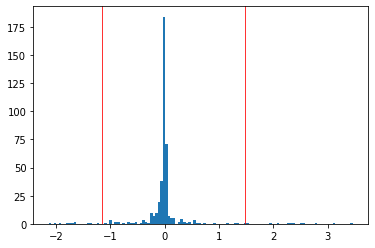

In [292]:
# Plot difference distribution between predict values and real values
plt.hist(diff_distribution, bins = 120)
plt.axvline(x = diff_distribution.quantile(.025), color = 'r', linewidth = 0.8)
plt.axvline(x = diff_distribution.quantile(.975), color = 'r', linewidth = 0.8)

In [270]:
outlier_indices = diff_distribution[(diff_distribution < diff_distribution.quantile(.025))|
                                    (diff_distribution > diff_distribution.quantile(.975))].index

In [271]:
outlier_indices

Int64Index([240, 345, 173, 174, 365, 407, 297, 298, 205, 362, 216, 200, 241,
            366, 206, 346, 301, 201, 411, 246, 408, 363],
           dtype='int64')

In [274]:
y[outlier_indices]

240    4.972500
345    5.500000
173    5.705714
174    3.281429
365    4.625000
407    6.164286
297    6.878571
298    3.972857
205    1.771429
362    1.760000
216    4.707143
200    5.682857
241    3.248571
366    1.840000
206    5.270000
346    3.128571
301    7.501429
201    3.261429
411    3.150000
246    1.885714
408    3.512857
363    4.840000
Name: retention_time, dtype: float64

In [272]:
data_met.loc[outlier_indices]

,Compound_name,Column,Organic_modifier,pH,Buffer,SMILES,retention_time,ABC,ABCGG,nAcid,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
240,Ketoconazole,HILIC,Methanol,3.0,Acetic acid,CC(=O)N1CCN(CC1)c1ccc(cc1)OC[C@H]1CO[C@](Cn2cc...,4.972500,28.538901,20.779696,0,...,0,0,0.245715,1.040042,0,0,0,0,0.401874,0.388067
345,Reserpine,HILIC,Methanol,3.0,Acetic acid,COc1ccc2c3CCN4CC5CC(C(C(C5CC4c3[nH]c2c1)C(=O)O...,5.500000,34.34129,25.180878,0,...,0,0.142857,2.34949,2.857624,0,0,0,0,0.333333,0
173,Flecainide,HILIC,Methanol,3.0,Acetic acid,C1CCNC(C1)CN=C(c1cc(ccc1OCC(F)(F)F)OCC(F)(F)F)O,5.705714,21.488118,17.268417,0,...,0.111111,0,0.447214,0.2,0,0,0,0.333333,0,0
174,Flecainide,HILIC,Methanol,3.0,Formic acid,C1CCNC(C1)CN=C(c1cc(ccc1OCC(F)(F)F)OCC(F)(F)F)O,3.281429,21.488118,17.268417,0,...,0.111111,0,0.447214,0.2,0,0,0,0.333333,0,0
365,Sudan I,HILIC,Methanol,3.0,Acetic acid,c1ccc(cc1)/N=N/c1c2ccccc2ccc1O,4.625000,14.837312,11.721991,0,...,0,0,0,0,0,0,0,1.0,0,0
407,Trimethoprim,HILIC,Methanol,3.0,Acetic acid,COc1cc(Cc2c[nH]c(=N)[nH]c2=N)cc(c1OC)OC,6.164286,15.653808,13.530766,0,...,0,0,0,0.90856,0.25,1.681793,0,0.5,0,0
297,O-Desmethylvenlafaxine,HILIC,Methanol,3.0,Acetic acid,CN(C)CC(c1ccc(cc1)O)C1(CCCCC1)O,6.878571,14.527174,12.678904,0,...,0,0.142857,0,0,0,0,0,0,0,0
298,O-Desmethylvenlafaxine,HILIC,Methanol,3.0,Formic acid,CN(C)CC(c1ccc(cc1)O)C1(CCCCC1)O,3.972857,14.527174,12.678904,0,...,0,0.142857,0,0,0,0,0,0,0,0
205,Hydrochlorothiazide,HILIC,Methanol,2.7,Formic acid,c1c(c(cc2c1NCNS2(=O)=O)S(=O)(=O)N)Cl,1.771429,13.427806,11.797726,0,...,0,1.44225,0,0,0,0.333333,0,0.5,0,0
362,Simvastatin,HILIC,Methanol,2.7,Formic acid,CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)...,1.760000,23.268833,18.862705,0,...,0,0.382096,1.259921,0.142857,0,0,0,0,0,0


In [275]:
data_met_clean = data_met.drop(outlier_indices)
data_met_clean.head()

,Compound_name,Column,Organic_modifier,pH,Buffer,SMILES,retention_time,ABC,ABCGG,nAcid,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,1-hydroxypyrene,HILIC,Methanol,2.7,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.794286,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
1,1-hydroxypyrene,HILIC,Methanol,3.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.545714,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
2,1-hydroxypyrene,HILIC,Methanol,3.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.790000,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
3,1-hydroxypyrene,HILIC,Methanol,5.0,Acetic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.534286,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0
4,1-hydroxypyrene,HILIC,Methanol,5.0,Formic acid,c1cc2ccc3ccc(c4ccc(c1)c2c34)O,1.792857,14.008885,10.537147,0,...,0,0,0,0,0,0,0,0,0,0


# data quality evalution by using RF, AutoGluon

In [276]:
#  Original data evalution
train, test = data_prep.make_train_test(data_met)
X_train = train.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_train = train['retention_time']
X_test = test.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_test = test['retention_time']

In [277]:
X_train.shape

(349, 1510)

In [278]:
# Random Forest Regressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [279]:
clf.score(X_train, y_train)

0.8720114623679343

In [280]:
clf.score(X_test, y_test)

0.7211257129554265

In [281]:
# AutoGluon
ap.autogluon_fit_train_test(train, test, 'not_cleaned_met')

Beginning AutoGluon training ...
AutoGluon will save models to "not_cleaned\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    349
Train Data Columns: 1513
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7.501428571428572, 1.34, 2.11061, 0.78486)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    8988.05 MB
	Train Data (Original)  Memory Usage: 17.0 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually spe

[1000]	valid_set's rmse: 0.602291
[2000]	valid_set's rmse: 0.59281


	-0.5915	 = Validation score   (root_mean_squared_error)
	1.95s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.616748


	-0.6154	 = Validation score   (root_mean_squared_error)
	1.86s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.5438	 = Validation score   (root_mean_squared_error)
	2.5s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: CatBoost ...
	-0.5692	 = Validation score   (root_mean_squared_error)
	333.2s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.5232	 = Validation score   (root_mean_squared_error)
	1.32s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.456	 = Validation score   (root_mean_squared_error)
	18.53s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: XGBoost ...
	-0.6054	 = Validation score   (root_mean_squared_error)
	17.38s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.51	 = Validation score   (root_mean_squared_error)
	35.99s	 = Training   runtime
	0.29s	 = Validation runtime
Fit

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.451193       0.643145   54.712699                0.000000           0.193044            2       True         12
1       NeuralNetFastAI  -0.456033       0.352079   18.525498                0.352079          18.525498            1       True          8
2        NeuralNetTorch  -0.510038       0.291066   35.994157                0.291066          35.994157            1       True         10
3         ExtraTreesMSE  -0.523197       0.211179    1.318303                0.211179           1.318303            1       True          7
4       RandomForestMSE  -0.543802       0.478107    2.496564                0.478107           2.496564            1       True          5
5              CatBoost  -0.569196       0.428097  333.204686                0.428097         333.

Evaluation: root_mean_squared_error on test data: -0.48579217168886996
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.48579217168886996,
    "mean_squared_error": -0.23599403407418842,
    "mean_absolute_error": -0.2415577899898024,
    "r2": 0.7691778058824208,
    "pearsonr": 0.8879622144232181,
    "median_absolute_error": -0.05571226392473472
}


{'root_mean_squared_error': -0.48579217168886996, 'mean_squared_error': -0.23599403407418842, 'mean_absolute_error': -0.2415577899898024, 'r2': 0.7691778058824208, 'pearsonr': 0.8879622144232181, 'median_absolute_error': -0.05571226392473472}


In [284]:
# Data evalution after cleanded mislabelled data 
train_clean, test_clean = data_prep.make_train_test(data_met_clean)
X_train = train_clean.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_train = train_clean['retention_time']
X_test = test_clean.drop(['retention_time','Column','Organic_modifier','Buffer'], axis =1)
y_test = test_clean['retention_time']

this dataset has split index already


In [285]:
X_train.shape

(332, 1510)

In [286]:
# Random Forest Regressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [288]:
clf.score(X_train, y_train)

0.9541455741014295

In [289]:
clf.score(X_test, y_test)
# somehow lower than original data fitting

0.6837982684161525

In [290]:
# AutoGluon
ap.autogluon_fit_train_test(train_clean, test_clean, 'cleaned_met')
# somehow lower than original data fitting

Beginning AutoGluon training ...
AutoGluon will save models to "cleaned_met\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    332
Train Data Columns: 1513
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5.764285714285714, 1.34, 2.03253, 0.56733)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9156.53 MB
	Train Data (Original)  Memory Usage: 16.17 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually sp

[1000]	valid_set's rmse: 0.254351


	-0.25	 = Validation score   (root_mean_squared_error)
	1.57s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.3128	 = Validation score   (root_mean_squared_error)
	2.42s	 = Training   runtime
	0.52s	 = Validation runtime
Fitting model: CatBoost ...
	-0.2762	 = Validation score   (root_mean_squared_error)
	1402.54s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.3076	 = Validation score   (root_mean_squared_error)
	1.3s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.2864	 = Validation score   (root_mean_squared_error)
	18.32s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2981	 = Validation score   (root_mean_squared_error)
	13.83s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.2807	 = Validation score   (root_mean_squared_error)
	54.71s	 = Training   runtime
	0.28s	 = Validation runtime


*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.243229       0.877207  1405.847225                0.001000           0.189043            2       True         12
1              LightGBM  -0.249986       0.221050     1.572237                0.221050           1.572237            1       True          4
2         LightGBMLarge  -0.255191       0.228057     1.547349                0.228057           1.547349            1       True         11
3              CatBoost  -0.276229       0.427099  1402.538596                0.427099        1402.538596            1       True          6
4        NeuralNetTorch  -0.280673       0.275062    54.712848                0.275062          54.712848            1       True         10
5       NeuralNetFastAI  -0.286360       0.326074    18.316647                0.326074      

Evaluation: root_mean_squared_error on test data: -0.35766517303805956
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.35766517303805956,
    "mean_squared_error": -0.12792437600434511,
    "mean_absolute_error": -0.17755797382073352,
    "r2": 0.6728881582422745,
    "pearsonr": 0.8552413954710301,
    "median_absolute_error": -0.09140217065811163
}


{'root_mean_squared_error': -0.35766517303805956, 'mean_squared_error': -0.12792437600434511, 'mean_absolute_error': -0.17755797382073352, 'r2': 0.6728881582422745, 'pearsonr': 0.8552413954710301, 'median_absolute_error': -0.09140217065811163}


In [ ]:
# useless code 

In [44]:
# t.interval(alpha=0.99, df= len(diff_distribution)-1, loc= np.mean(diff_distribution), scale= st.sem(diff_distribution)) 
# test = [1,2,3,4,5,6,7,8,9,10]
# m = statistics.mean(test)
# s = statistics.pstdev(test)
# dof = len(test)-1
# confidence = 0.99
# t_crit = np.abs(t.ppf((1-confidence)/2,dof))
# (m-s*t_crit/np.sqrt(len(test)), m+s*t_crit/np.sqrt(len(test)))

(2.5481902793209756, 8.451809720679025)

In [ ]:
# clf = LinearRegression()
# num_crossval_folds = LeaveOneOut()

# for i in range(0,1):
#     y_pred = cross_val_predict(
#         clf,
#         X,
#         y,
#         cv = kf
#     )
#     data['diff'] = diff
#     diff = diff.tolist()
#     diff_distribution.extend(diff)

In [137]:
# SEED = 123456
# np.random.seed(SEED)
# random.seed(SEED)

# skf = StratifiedKFold(n_splits=2)
# skf.get_n_splits(X)

# start = time.time()    
# diff_distribution = []    
# clf = RandomForestRegressor()
# compound = data['Compound_name']
# for train_index, test_index in skf.split(X,compound):
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     diff_distribution.extend(y_test - y_pred) 
#     print(y_test.index)
# end = time.time()

Int64Index([  1,   3,   5,   6,   8,   9,  13,  14,  16,  18,
            ...
            396, 397, 399, 400, 403, 405, 406, 407, 410, 413],
           dtype='int64', length=207)
Int64Index([  0,   2,   4,   7,  10,  11,  12,  15,  17,  19,
            ...
            393, 394, 398, 401, 402, 404, 408, 409, 411, 412],
           dtype='int64', length=207)


In [ ]:
# diff_mean = statistics.mean(diff_distribution)
# diff_std = statistics.pstdev(diff_distribution)
# upper = diff_mean + 2*diff_std
# lower =diff_mean - 2*diff_std
# outlier = diff_distribution[(diff_distribution > upper) or (diff_distribution < lower)]
# diff_distribution = np.array(diff_distribution)
# inlier = diff_distribution[(diff_distribution>np.quantile(diff_distribution,0.025)) & (diff_distribution<np.quantile(diff_distribution,0.975))].tolist()
# outlier = [x for x in diff_distribution if (x not in inlier)]
# diff_distribution = np.array(diff_distribution)
# from scipy.stats import zscore
# outlier_indices = np.where(np.absolute(zscore(diff_distribution)) > 2)[0]
# outlier_indices = diff_distribution[zscore(diff_distribution).abs() > 2].index